# Data reading and cleaning

In [23]:
import pandas as pd
import numpy as np

file_path = "./archive/USvideos.csv"
usVideos = pd.read_csv(file_path)

# Clean null values and format dates
# print("Raw usVideos")
# print(usVideos)
usVideos = usVideos[usVideos["title"].notna()]
usVideos = usVideos[usVideos["description"].notna()]
usVideos["trending_date"] = pd.to_datetime(usVideos["trending_date"], format="%y.%d.%m")
usVideos["publish_time"] = usVideos["publish_time"].apply(lambda row: row[:-11].replace("T", " "))
usVideos["publish_time"] = pd.to_datetime(usVideos["publish_time"], format="%Y-%m-%d %H") 
usVideos = usVideos[usVideos["video_id"].notna()]
usVideos = usVideos.drop_duplicates(subset=['video_id'])

# Compute features including title lengths, tag lengths, net likes, and trending day differences
usVideos["description_count"] = usVideos["description"].apply(lambda row: len(row))
usVideos["title_count"] = usVideos["title"].apply(lambda row: len(row))
usVideos["channel_title_count"] = usVideos["channel_title"].apply(lambda row: len(row))
usVideos["net_likes"] = usVideos["likes"] - usVideos["dislikes"]
popular_thres = 10000
usVideos["popular"] = np.int32(usVideos["net_likes"] > popular_thres)
usVideos["trending_minute_differences"] = usVideos["trending_date"] - usVideos["publish_time"]
usVideos["trending_minute_differences"] = usVideos["trending_minute_differences"].apply(lambda row: row.seconds / 60)
usVideos["tags_count"] = usVideos["tags"].apply(lambda row: len(row.split("|")))
usVideos["tags_avg_length"] = usVideos["tags"].apply(lambda row: np.mean(list(map(lambda x: len(x), row.split("|")))))
boolRows = ["comments_disabled", "ratings_disabled", "video_error_or_removed"]
for i in boolRows:
    usVideos[i] = usVideos[i].astype(int)
# print("usVideos features computed:")
# print(usVideos)

# TODO: Advanced features computations including title_sentiment, channel_title_sentiment, description_sentiment, tags_sentiment

# Select features useful for training
id = ["video_id"]
xs = ["category_id", "comments_disabled", "ratings_disabled", "video_error_or_removed", "title_count", "channel_title_count", "tags_count", "tags_avg_length"]
ys =  ["popular"]
# ys =  ["views", "likes", "dislikes", "trending_minute_differences", "net_likes", "popular"]
usVideosCleaned = usVideos[id + xs + ys]
print("usVideos filtered contain:")
print(usVideosCleaned.columns)




usVideos filtered contain:
Index(['video_id', 'category_id', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'title_count', 'channel_title_count',
       'tags_count', 'tags_avg_length', 'popular'],
      dtype='object')


# Feature Visualizations

# Model construction

## PCA + MLP

In [22]:
# Determine dataset partitions and labels
size = len(usVideosCleaned)
print(size)
test_size = size // 4
train_size = size - test_size
partitions = {"train": usVideosCleaned["video_id"][:train_size].to_list(), 
              "test": usVideosCleaned["video_id"][train_size:].to_list()}
labels = dict(zip(partitions["train"]+partitions["test"], usVideosCleaned["popular"])) # classifying whether the video is popular
# print(partitions)
# print(labels)


6254


In [6]:
# Do dimensionality reduction to extract key features
from sklearn.decomposition import PCA
import pandas as pd
# from copy import copy

def pca_decompose(ds, n_components=4):
    if (n_components==8):
        return ds
    vid = ds["video_id"].to_list()
    ds = ds.drop(columns=["video_id"])
    print("Before PCA: {}".format(ds.shape))  
    # print(ds)  
    pca = PCA(n_components=n_components)
    ds_pca = pca.fit_transform(ds)
    print("After PCA: {}".format(ds_pca.shape))  
    ds_pca = pd.DataFrame(ds_pca)
    ds_pca["video_id"] = vid
    # print(ds_pca)  
    return ds_pca


In [8]:
# Dataset definitions
import torch

params = {'batch_size': 64,'shuffle': True,'num_workers': 6}
# id_col = usVideosCleaned["video_id"] 
label_col = usVideosCleaned["popular"] 
# usVideosCleaned = usVideosCleaned.drop(columns=["popular", "video_id"])
usVideosCleanedFeats = usVideosCleaned.drop(columns=["popular"])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, list_ids, labels, data):
        self.data = data
        self.labels = labels
        self.list_ids = list_ids
    def __len__(self):
        """Denoting the total number of samples"""
        # print("getting len {}".format(len(self.list_ids)))
        # print(len(self.list_ids))
        return len(self.list_ids)
    def __getitem__(self, index):
        """generator fetching one data and one label. Return: X, y"""
        # print(self.data)
        # print(self.data["video_id"])
        curr_id = self.list_ids[index]
        y = self.labels[curr_id]
        X = self.data.loc[self.data["video_id"]==curr_id, :]
        X = X.drop(columns=["video_id"])
        X = X.to_numpy()
        # X = X.astype(np.float32)
        # print(X, y)
        # print(X.shape, X.dtype, type(y))
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Dataset Preparations
def prepare_usvideos_dataset(labels, data, partition, params=params):
    training_set = Dataset(partition['train'], labels, data)
    training_generator = torch.utils.data.DataLoader(training_set, **params)
    test_set = Dataset(partition['test'], labels, data)
    test_generator = torch.utils.data.DataLoader(test_set, **params)
    return training_generator, test_generator
        
dataset_params = {'batch_size': 1024,'shuffle': True,'num_workers': 0}
print("Dataset size: {}".format(len(usVideosCleanedFeats)))
usVideosCleanedFeats = pca_decompose(usVideosCleanedFeats)
train_dl, test_dl = prepare_usvideos_dataset(labels, usVideosCleanedFeats, partitions, params=dataset_params)

print(usVideosCleanedFeats.columns)
# print(len(train_dl.dataset),len(test_dl.dataset))

Dataset size: 6254
Before PCA: (6254, 8)
After PCA: (6254, 4)
Index([0, 1, 2, 3, 'video_id'], dtype='object')


In [11]:
# MLP definitions
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_dim=8, out_dim=1):
        super(MLP, self).__init__()
        assert out_dim==1, 'out_dim must be 1'
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear1 = nn.Linear(self.in_dim, 64)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 256)
        self.act2 = nn.ReLU()
        self.linear3 = nn.Linear(256, 512)
        self.act3 = nn.ReLU()
        self.linear4 = nn.Linear(512, 128)
        self.act4 = nn.ReLU()
        self.linear5 = nn.Linear(128, 64)
        self.act5 = nn.ReLU()
        self.linear6 = nn.Linear(64, self.out_dim)
        self.act6 = nn.Sigmoid()
    def forward(self, x):
        # print("stt", x.shape)
        x = self.act1(self.linear1(x))
        # print("lin1pass", x.shape)
        x = self.act2(self.linear2(x))
        # print("lin2pass", x.shape)
        x = self.act3(self.linear3(x))
        x = self.act4(self.linear4(x))
        x = self.act5(self.linear5(x))
        x = self.act6(self.linear6(x))
        return torch.squeeze(x)
    

In [184]:
# Model training stuffs
import time
import torch
import os

def train_model(train_dl, model, epochs=100, lr=0.01, momentum=0.9, save_step=10, save_dir='models'):
    # Define your optimisation function for reducing loss when weights are calculated 
    # and propogated through the network
    start = time.time()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = 0.0

    for epoch in range(epochs):
        model.train()
        # print('train mode entered')
        # Iterate through training data loader
        losses = []
        for i, (inputs, targets) in enumerate(train_dl):
            # print(inputs.shape, targets.shape)
            optimizer.zero_grad()
            # print("sttinp")
            outputs = model(inputs)
            # print("getout")
            # _, preds = torch.max(outputs.data,1) #Get the class labels
            # print(outputs, targets)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            # print("getloss")
            loss.backward()
            # print("bgprob")
            optimizer.step()
        epoch_loss = sum(losses)/len(losses)
        if (epoch%save_step==0):
            print("Saving model at step {}".format(epoch+1))
            save_path = os.path.join(save_dir, "model_{}.pth".format(epoch))
            torch.save(model.state_dict(), save_path)
        print('Epoch {}/{}. CE Loss {}'.format(epoch+1, epochs, epoch_loss))
        # print('-' * 10)
    time_delta = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_delta // 60, time_delta % 60
    ))
    save_path = os.path.join(save_dir, "model_final.pth")
    print("Final save of model to {}.".format(save_path))
    torch.save(model.state_dict(), save_path)
    return model

In [185]:
# Build the model
model = MLP(in_dim=4)
train_model(train_dl, model, 
            save_step=10, 
            save_dir='models',
            epochs=100, 
            lr=0.1)


Saving model at step 1
Epoch 1/100. CE Loss 0.6493282079696655
Epoch 2/100. CE Loss 0.6321143269538879
Epoch 3/100. CE Loss 0.6280970931053161
Epoch 4/100. CE Loss 0.6205885171890259
Epoch 5/100. CE Loss 0.624156391620636
Epoch 6/100. CE Loss 0.6223018407821655
Epoch 7/100. CE Loss 0.6177451610565186
Epoch 8/100. CE Loss 0.6218402266502381
Epoch 9/100. CE Loss 0.6190341472625732
Epoch 10/100. CE Loss 0.6200924038887023
Saving model at step 11
Epoch 11/100. CE Loss 0.6182940840721131
Epoch 12/100. CE Loss 0.6161196112632752
Epoch 13/100. CE Loss 0.6165620446205139
Epoch 14/100. CE Loss 0.6135132670402527
Epoch 15/100. CE Loss 0.6153320789337158
Epoch 16/100. CE Loss 0.6126574277877808
Epoch 17/100. CE Loss 0.6143855452537537
Epoch 18/100. CE Loss 0.6134192824363709
Epoch 19/100. CE Loss 0.6106968760490418
Epoch 20/100. CE Loss 0.6131567597389221
Saving model at step 21
Epoch 21/100. CE Loss 0.6128958582878112
Epoch 22/100. CE Loss 0.6079392194747925
Epoch 23/100. CE Loss 0.6101781606674

MLP(
  (linear1): Linear(in_features=4, out_features=64, bias=True)
  (act1): ReLU()
  (linear2): Linear(in_features=64, out_features=256, bias=True)
  (act2): ReLU()
  (linear3): Linear(in_features=256, out_features=512, bias=True)
  (act3): ReLU()
  (linear4): Linear(in_features=512, out_features=128, bias=True)
  (act4): ReLU()
  (linear5): Linear(in_features=128, out_features=64, bias=True)
  (act5): ReLU()
  (linear6): Linear(in_features=64, out_features=1, bias=True)
  (act6): Sigmoid()
)

# Model evaluations

## MLP + PCA

In [1]:
# Model evaluation stuffs
import math
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, average_precision_score

def predict(row, model):
    row = torch.Tensor([row])
    yhat = model(row)
    # Get numpy array
    yhat = yhat.detach().numpy()
    return yhat  

def evaluate_model(test_dl, model, beta=1.0):
    preds = np.zeros((len(test_dl.dataset)))
    actuals = np.zeros((len(test_dl.dataset)))
 
    curr_ind = 0
    for (i, (inputs, targets)) in enumerate(test_dl):
        # print(inputs.shape, targets.shape)
        #Evaluate the model on the test set
        yhat = model(inputs)
        #Retrieve a numpy weights array
        yhat = yhat.detach().numpy()
        # Extract the weights using detach to get the numerical values in an ndarray, instead of tensor
        targets = targets.numpy()
        # Round to get the class value i.e. sick vs not sick
        yhat = yhat.round()
        # Store the predictions in the empty lists initialised at the start of the class
        # print(yhat.shape, targets.shape)
        # print(preds.shape, actuals.shape)
        batch_size = len(yhat)
        preds[curr_ind:curr_ind+batch_size] = yhat
        actuals[curr_ind:curr_ind+batch_size] = targets
        curr_ind += batch_size
     
    #Calculate metrics
    cm = confusion_matrix(actuals, preds)
    # Get descriptions of tp, tn, fp, fn
    tn, fp, fn, tp = cm.ravel()
    total = sum(cm.ravel())
     
    metrics = {
        'accuracy': accuracy_score(actuals, preds),
        'AU_ROC': roc_auc_score(actuals, preds),
        'f1_score': f1_score(actuals, preds),
        'average_precision_score': average_precision_score(actuals, preds),
        'f_beta': ((1+beta**2) * precision_score(actuals, preds) * recall_score(actuals, preds)) / (beta**2 * precision_score(actuals, preds) + recall_score(actuals, preds)),
        'matthews_correlation_coefficient': (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)),
        'precision': precision_score(actuals, preds),
        'recall': recall_score(actuals, preds),
        'true_positive_rate_TPR':recall_score(actuals, preds),
        'false_positive_rate_FPR':fp / (fp + tn) ,
        'false_discovery_rate': fp / (fp +tp),
        'false_negative_rate': fn / (fn + tp) ,
        'negative_predictive_value': tn / (tn+fn),
        'misclassification_error_rate': (fp+fn)/total ,
        'sensitivity': tp / (tp + fn),
        'specificity': tn / (tn + fp),
        #'confusion_matrix': confusion_matrix(actuals, preds), 
        'TP': tp,
        'FP': fp, 
        'FN': fn, 
        'TN': tn
    }
    return metrics, preds, actuals

def get_model_eval_metrics(test_dl, model_path, in_dim):
    model = MLP(in_dim=in_dim)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return evaluate_model(test_dl, model)
    
    

In [24]:
# Determine dataset partitions and labels
size = len(usVideosCleaned)
print(size)
test_size = size // 4
train_size = size - test_size
partitions = {"train": usVideosCleaned["video_id"][:train_size].to_list(), 
              "test": usVideosCleaned["video_id"][train_size:].to_list()}
labels = dict(zip(partitions["train"]+partitions["test"], usVideosCleaned["popular"])) # classifying whether the video is popular
# print(partitions)
# print(labels)


6254


### Comparisons for MLP with and without PCA, as well as PCAs with different number of components:

In [12]:
# Comparing MLP performance with and without PCA
import matplotlib.pyplot as plt
import numpy as np 

# Get overall evaluations
acc, auroc, f1 = [], [], []
model_no_pca_path = "models/mlp_no_pca/model_final.pth"
model_pca2_path = "models/mlp_with_pca_comp2/model_final.pth"
model_pca3_path = "models/mlp_with_pca_comp3/model_final.pth"
model_pca4_path = "models/mlp_with_pca_comp4/model_final.pth"
model_pca4_optim_path = "models/mlp_with_pca_comp4/optim_model_80.pth"
pca_model_paths = [model_no_pca_path, model_pca2_path, model_pca3_path, model_pca4_path, model_pca4_optim_path]
input_dims = [8, 2, 3, 4, 4]
for p, d in zip(pca_model_paths, input_dims):
    # Determine datasets for different number of PCA components
    label_col = usVideosCleaned["popular"] 
    usVideosCleanedFeats = usVideosCleaned.drop(columns=["popular"])
    usVideosCleanedFeats = pca_decompose(usVideosCleanedFeats, n_components=d)
    _, test_dl = prepare_usvideos_dataset(labels, usVideosCleanedFeats, partitions, params=dataset_params)

    # Evaluate to get metrics
    pca_metrics, _, _ = get_model_eval_metrics(test_dl, p, in_dim=d)
    acc.append(pca_metrics["accuracy"])
    auroc.append(pca_metrics["AU_ROC"])
    f1.append(pca_metrics["f1_score"])



Before PCA: (6254, 8)
After PCA: (6254, 2)
Before PCA: (6254, 8)
After PCA: (6254, 3)
Before PCA: (6254, 8)
After PCA: (6254, 4)
Before PCA: (6254, 8)
After PCA: (6254, 4)


[0.490722968650032, 0.417786308381318, 0.43570057581573896, 0.4984005118362124, 0.5431861804222649]


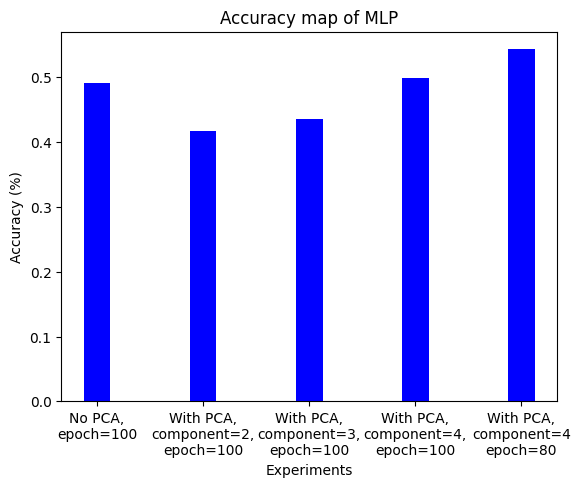

In [25]:
# Plot accuracy map
N = len(pca_model_paths)
ind = np.arange(N)  
width = 0.25
  
bar2 = plt.bar(ind, acc, width, color = 'b') 
print(acc)
plt.xlabel("Experiments") 
plt.ylabel('Accuracy (%)') 
plt.title("Accuracy map of MLP") 
  
plt.xticks(ind,['No PCA,\nepoch=100', 'With PCA,\ncomponent=2,\nepoch=100', 'With PCA,\ncomponent=3,\nepoch=100', 'With PCA,\ncomponent=4,\nepoch=100', 'With PCA,\ncomponent=4\nepoch=80']) 
# plt.legend(bar1) 
plt.show() 



### Confusion Matrix of the best model:

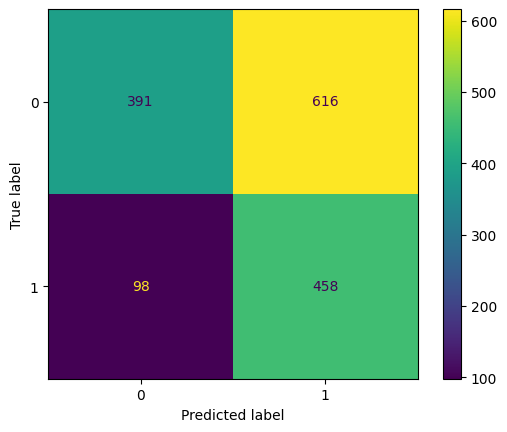

In [15]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_pca_path = "models/mlp_with_pca_comp4/optim_model_80.pth"
pca_metrics, preds, actuals = get_model_eval_metrics(test_dl, model_pca_path, in_dim=4)

conf_mat = confusion_matrix(preds, actuals) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()